# Experiment 3: Memory Corridor Results

In [1]:
import os
import sys
# import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


sys.path.append('..')
from utils import load_yaml_config

In [35]:
def get_npy_metric(log_path, metric_name):
    arrs = []
    for subdir, dirs, files in os.walk(log_path):
        for file in files:
            filepath = subdir + os.sep + file

            if filepath.endswith(f"{metric_name}.npy"):
                arrs.append(np.load(filepath))
    return np.array(arrs)

def create_eval_results(path):
    eval_rewards = get_npy_metric(path, "eval_rewards")
    # Mean over independent runs
    y_t = np.mean(eval_rewards, axis=0)
    # Mean over testing environments
    if np.ndim(y_t) > 1:
        y = np.mean(y_t, axis=1)
        std = np.std(y_t, axis=1)
    else:
        y = y_t
        std = np.std(eval_rewards, axis=0)
    x = np.linspace(0, 1e7, len(y))

    return x, y, std

def get_runtime(path):
    runtime = get_npy_metric(path, "runtime")
    return np.mean(runtime, axis=0)

def get_config(log_path):
    for subdir, dirs, files in os.walk(log_path):
        for file in files:
            filepath = subdir + os.sep + file

            if filepath.endswith(f".yaml"):
                return load_yaml_config(filepath)

In [36]:
folder = "/home/tom/Documents/Master/Thesis/results/Experiment 3"

subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]

def get_model_metrics(model):
    performance_dict = {}
    runtime_dict = {}
    for subfolder in subfolders:
        subsubfolders = [ f.path for f in os.scandir(subfolder) if f.is_dir() ]
        for subsubfolder in subsubfolders:
            model_name = os.path.basename(os.path.normpath(subsubfolder))
            environment_name = os.path.basename(os.path.normpath(subfolder))
            if model_name == model:
                performance_dict[environment_name] = create_eval_results(subsubfolder)
                runtime_dict[environment_name] = get_runtime(subsubfolder)
    return performance_dict, runtime_dict

s5_perf_dict, s5_runtime_dict = get_model_metrics("S5")
GRU_perf_dict, GRU_runtime_dict = get_model_metrics("GRU")

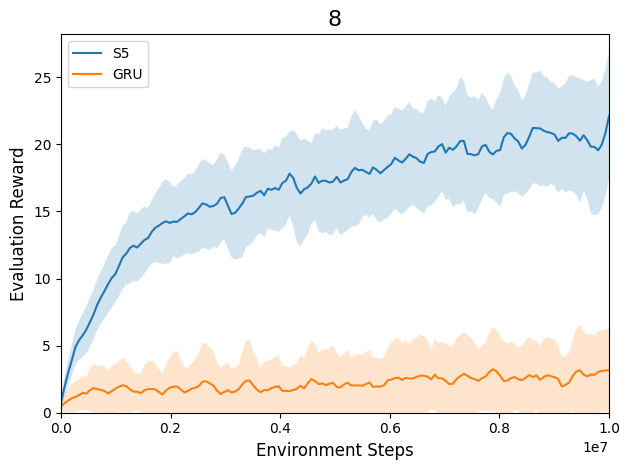

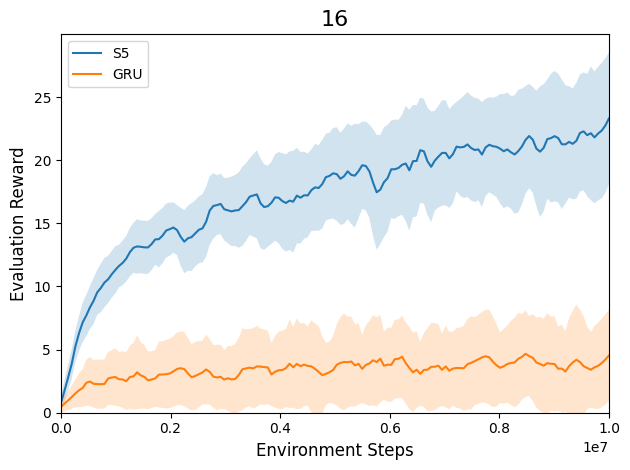

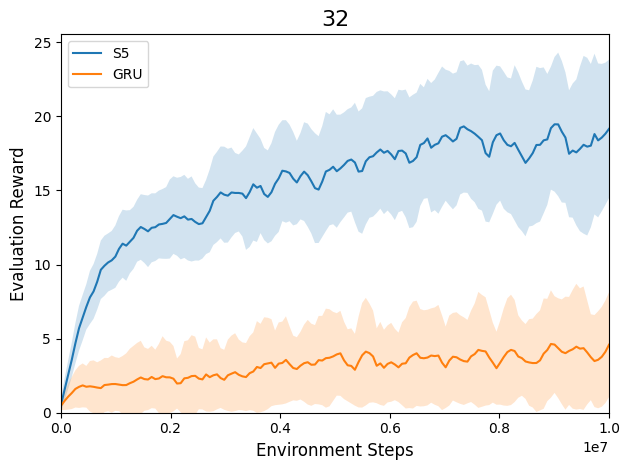

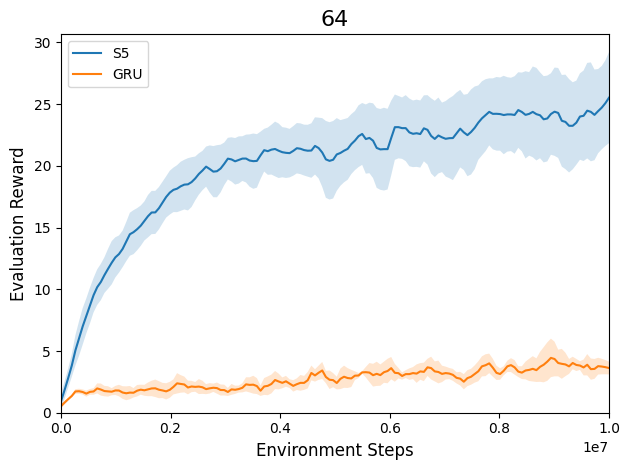

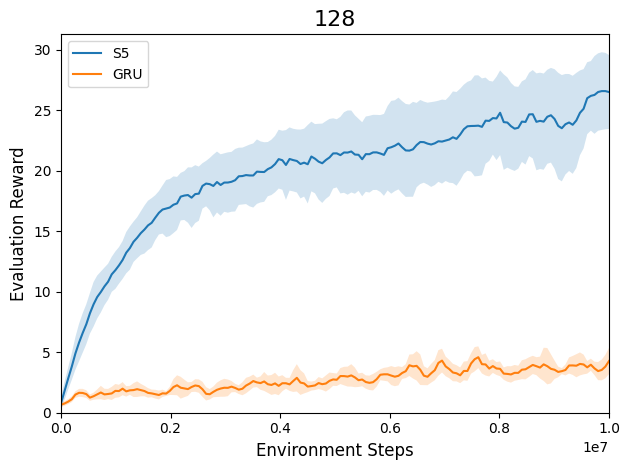

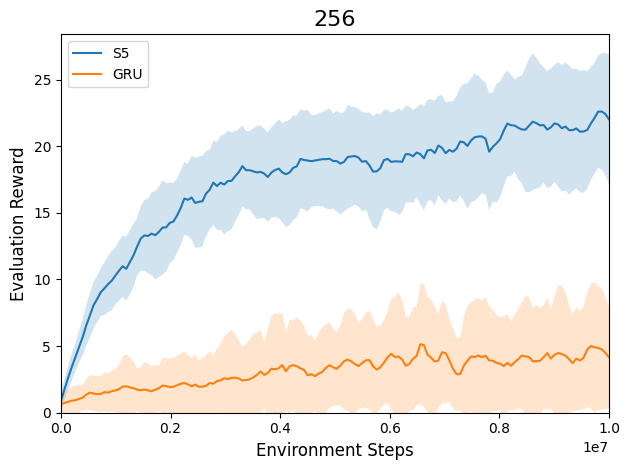

In [38]:
for key in s5_perf_dict.keys():
    fig, ax = plt.subplots(1,1)

    #S5
    x, y, std = s5_perf_dict[key]
    y = savgol_filter(y, 7, 2)
    std = savgol_filter(std, 7, 2)
    ax.plot(x, y, label="S5")
    ax.fill_between(x, y - std, y + std, alpha=0.2)
    # GRU
    if key in GRU_perf_dict.keys():
        
        x, y, std = GRU_perf_dict[key]
        y = savgol_filter(y, 7, 2)
        std = savgol_filter(std, 7, 2)
        ax.fill_between(x, y - std, y + std, alpha=0.2)
        ax.plot(x, y, label="GRU")

    #
    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Evaluation Reward', fontsize=12)
    ax.set_title(key, fontsize=16)
    ax.set_xlim(0, 1e7)
    ax.set_ylim(0, None)
    plt.legend()
    plt.tight_layout()
    plt.show()

# All in same plot

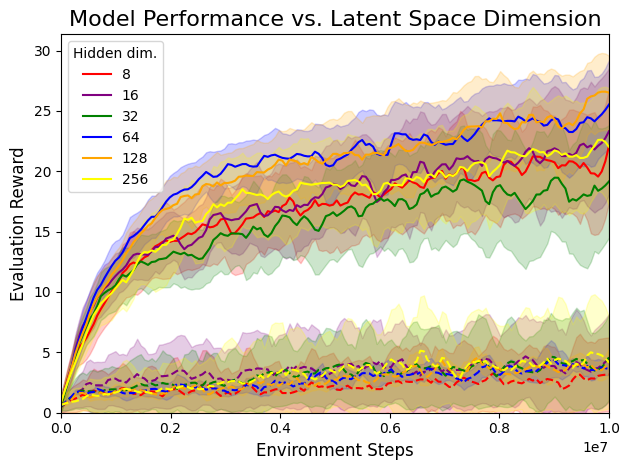

In [40]:
colorlist = ['red','purple', 'green', 'blue', 'orange', 'yellow']

fig, ax = plt.subplots(1,1)
for i, key in enumerate(s5_perf_dict.keys()):

    #S5
    x, y, std = s5_perf_dict[key]
    y = savgol_filter(y, 7, 2)
    std = savgol_filter(std, 7, 2)
    ax.plot(x, y, label=f"{key}", color=colorlist[i])
    ax.fill_between(x, y - std, y + std, color = colorlist[i], alpha=0.2)
    # GRU
    if key in GRU_perf_dict.keys():
        x, y, std = GRU_perf_dict[key]
        y = savgol_filter(y, 7, 2)
        std = savgol_filter(std, 7, 2)
        ax.plot(x, y, color=colorlist[i], linestyle='dashed')
        ax.fill_between(x, y - std, y + std, color = colorlist[i], alpha=0.2)

    #
ax.set_xlabel('Environment Steps', fontsize=12)
ax.set_ylabel('Evaluation Reward', fontsize=12)
ax.set_title("Model Performance vs. Latent Space Dimension", fontsize=16)
ax.set_xlim(0, 1e7)
ax.set_ylim(0, None)
plt.legend(title='Hidden dim.')
plt.tight_layout()
plt.show()

# Bar Chart

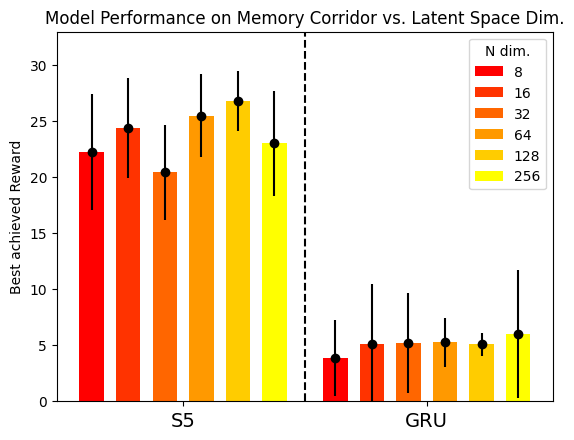

In [47]:
from matplotlib import colormaps

fig, ax = plt.subplots(1,1)

colorlist = ['red','purple', 'green', 'blue', 'orange', 'yellow']
colorlist = colormaps['autumn'](np.linspace(0, 1, len(s5_perf_dict.keys())))

# options: ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
#                       'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
#                       'tab20c']

bar_width = 0.2
multiplier = 0

x = 0

for i, (N, performance) in enumerate(s5_perf_dict.items()):
    _, y, std = s5_perf_dict[N]
    val = np.max(y)
    val_std = std[np.argmax(y)]
    offset = bar_width * multiplier 
    rects = ax.bar(
        x + offset, val, bar_width, label=N, color=colorlist[i]
    )
    ax.errorbar(x + offset, 
                y= val, 
                yerr= val_std,
                fmt='o',
                color='black'
            )
    x += bar_width / 2
    multiplier += 1

x += 0.2 
ax.vlines(x + offset- 0.05, ymin=0, ymax=33, color='black', linestyles='dashed')

for  i, (N, performance) in enumerate(GRU_perf_dict.items()):
    _, y, std = GRU_perf_dict[N]
    val = np.max(y)
    val_std = std[np.argmax(y)]
    offset = bar_width * multiplier 
    rects = ax.bar(
        x + offset, val, bar_width, color=colorlist[i]
    )
    ax.errorbar(x + offset, 
                y= val, 
                yerr= val_std,
                fmt='o',
                color='black'
            )
    x += bar_width / 2
    multiplier += 1


ax.legend(title="N dim.")#, bbox_to_anchor=(1.1, 0.3))
# ax.set_xticks(x + 0.5 *offset, [f"{res} layers" for res in residual_list])
ax.set_ylabel('Best achieved Reward')
ax.set_ylim(0, 33)
ax.set_xticks([0.75, 2.75], ['S5', 'GRU'], fontsize=14)
ax.set_title('Model Performance on Memory Corridor vs. Latent Space Dim.')
plt.show()

# Comparison to Flax implementation Chris Lu

In [6]:
folder = "/home/tom/Documents/Master/Thesis/results/Experiment 3 ChrisLu"

subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]

def get_ChrisLu_npy_metric(log_path, metric_name):
    for subdir, dirs, files in os.walk(log_path):
        for file in files:
            filepath = subdir + os.sep + file

            if filepath.endswith(f"{metric_name}.npy"):
                return np.load(filepath)

def get_ChrisLu_results(path):
    eval_rewards = get_ChrisLu_npy_metric(path, "out")
    y = np.mean(eval_rewards, axis=0)
    std = np.std(eval_rewards, axis=0),
    x = np.linspace(0, 1e7, len(y))

    return x, y, std

def get_model_metrics(model):
    performance_dict = {}
    runtime_dict = {}
    for subfolder in subfolders:
        subsubfolders = [ f.path for f in os.scandir(subfolder) if f.is_dir() ]
        for subsubfolder in subsubfolders:
            model_name = os.path.basename(os.path.normpath(subsubfolder))
            environment_name = os.path.basename(os.path.normpath(subfolder))
            if model_name == model:
                performance_dict[environment_name] = get_ChrisLu_results(subsubfolder)
    return performance_dict, runtime_dict

s5_perf_dict, s5_runtime_dict = get_model_metrics("S5")
GRU_perf_dict, GRU_runtime_dict = get_model_metrics("GRU")

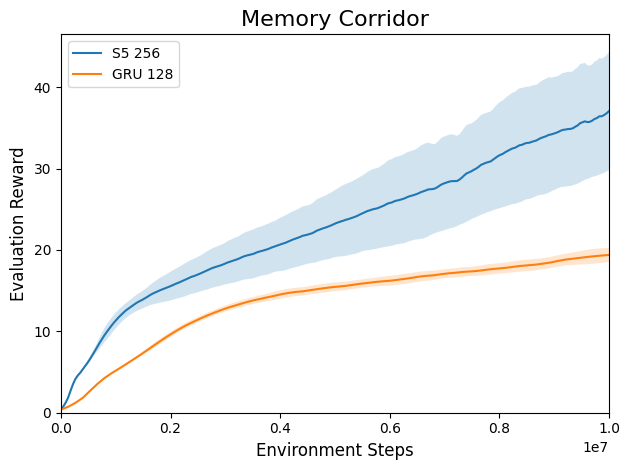

In [ ]:
fig, ax = plt.subplots(1,1)

for key in s5_perf_dict.keys():
    #S5
    x, y, std = s5_perf_dict[key]
    y = savgol_filter(y, 7, 2)
    std = savgol_filter(std[0], 7, 2)
    ax.plot(x, y, label=f"S5 {key}")
    ax.fill_between(x, y - std, y + std, alpha=0.2)

for key in GRU_perf_dict.keys():
    # GRU
    x, y, std = GRU_perf_dict[key]
    y = savgol_filter(y, 7, 2)
    std = savgol_filter(std[0], 7, 2)
    ax.fill_between(x, y - std, y + std, alpha=0.2)
    ax.plot(x, y, label=f"GRU {key}")

    #
ax.set_xlabel('Environment Steps', fontsize=12)
ax.set_ylabel('Evaluation Reward', fontsize=12)
ax.set_title("Memory Corridor", fontsize=16)
ax.set_xlim(0, 1e7)
ax.set_ylim(0, None)
plt.legend()
plt.tight_layout()
plt.show()

# Long running experiment

In [48]:
folder = "/home/tom/Documents/Master/Thesis/results/Experiment 3 Long"

subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]

def get_model_metrics(model):
    performance_dict = {}
    runtime_dict = {}
    for subfolder in subfolders:
        subsubfolders = [ f.path for f in os.scandir(subfolder) if f.is_dir() ]
        for subsubfolder in subsubfolders:
            model_name = os.path.basename(os.path.normpath(subsubfolder))
            environment_name = os.path.basename(os.path.normpath(subfolder))
            if model_name == model:
                performance_dict[environment_name] = create_eval_results(subsubfolder)
                runtime_dict[environment_name] = get_runtime(subsubfolder)
    return performance_dict, runtime_dict

s5_perf_dict, s5_runtime_dict = get_model_metrics("S5")

In [57]:
x, y, std = s5_perf_dict['256']
print(np.max(y))

45.3125


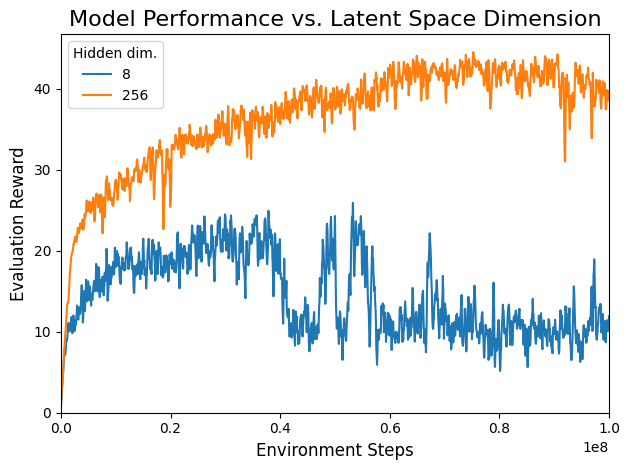

In [54]:
colorlist = ['red','purple', 'green', 'blue', 'orange', 'yellow']

fig, ax = plt.subplots(1,1)
for i, key in enumerate(s5_perf_dict.keys()):

    #S5
    x, y, std = s5_perf_dict[key]
    x = np.linspace(0, 1e8, len(y))
    y = savgol_filter(y, 7, 2)
    std = savgol_filter(std, 7, 2)
    ax.plot(x, y, label=f"{key}")
    # ax.fill_between(x, y - std, y + std, color = colorlist[i], alpha=0.2)

ax.set_xlabel('Environment Steps', fontsize=12)
ax.set_ylabel('Evaluation Reward', fontsize=12)
ax.set_title("Model Performance vs. Latent Space Dimension", fontsize=16)
ax.set_xlim(0, 1e8)
ax.set_ylim(0, None)
plt.legend(title='Hidden dim.')
plt.tight_layout()
plt.show()